In [0]:
!pip3 -qq install torch==0.4.1
!pip install -qq bokeh==0.13.0
!pip install -qq eli5==0.8
!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5"

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    
np.random.seed(42)

# Свёрточные нейронные сети

## Классификация фамилий

Будем учиться предсказывать, является ли слово фамилией.

In [0]:
from sklearn.model_selection import train_test_split

with open('surnames.txt') as f:
    lines = f.readlines()
    data = [line.strip().split('\t')[0] for line in lines]
    labels = np.array([int(line.strip().split('\t')[1]) for line in lines])
    del lines
    
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=42)

Посмотрим на данные:

In [314]:
list(zip(train_data, train_labels))[::1500]

[('вожакам', 0),
 ('посвящения', 0),
 ('изменницы', 0),
 ('тензорам', 0),
 ('Родзевич', 1),
 ('поломку', 0),
 ('ПРОВЕРКАМ', 0),
 ('майка', 0),
 ('ошеломлении', 0),
 ('эркере', 0),
 ('дешифрировании', 0),
 ('затоваривание', 0),
 ('громыханий', 0),
 ('выволочка', 0),
 ('Волдыри', 0),
 ('сербки', 0),
 ('ОТЛИЧИИ', 0),
 ('РАДИОГРАММА', 0),
 ('поэтике', 0),
 ('гобоя', 0),
 ('ОБЛАСТЯМИ', 0),
 ('пациентах', 0),
 ('трясогузка', 0),
 ('утепления', 0),
 ('Фингалу', 0),
 ('Хищение', 0),
 ('Джамал', 0),
 ('Лавчонка', 0),
 ('скольжению', 0),
 ('восстание', 0),
 ('Гудмэн', 1),
 ('консортах', 0),
 ('инфузорий', 0),
 ('постоянстве', 0),
 ('вахтенными', 0),
 ('полновластия', 0)]

Данные ещё и сильно несбалансированы - положительных примеров в несколько раз меньше:

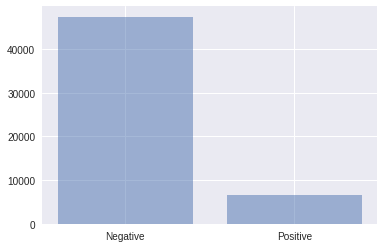

In [315]:
import matplotlib.pyplot as plt
%matplotlib inline

positive_count = np.sum(train_labels == 1)
negative_count = len(train_labels) - positive_count
 
plt.bar(np.arange(2), [negative_count, positive_count], align='center', alpha=0.5)
plt.xticks(np.arange(2), ('Negative', 'Positive'))
    
plt.show()

Accuracy очень легко оптимизировать - просто предсказывайте всегда ноль:

In [316]:
print('Accuracy = {:.2%}'.format((train_labels == 0).mean()))

Accuracy = 87.90%


Однако это будет довольно бесполезно - всегда говорить, что слово не является фамилией. Это, конечно, вопрос - что хуже, зря объявить слово фамилией (ошибка первого рода) или не найти фамилию.

![](https://effectsizefaq.files.wordpress.com/2010/05/type-i-and-type-ii-errors.jpg =x350)  
*From [effectsizefaq.com](https://effectsizefaq.com/2010/05/31/i-always-get-confused-about-type-i-and-ii-errors-can-you-show-me-something-to-help-me-remember-the-difference/)*

Будем замерять precision, recall и их комбинацию - $F_1$-меру.

![precision-recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png =x600)  
*From [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)*

$$\text{precision} = \frac{tp}{tp + fp}.$$
$$\text{recall} = \frac{tp}{tp + fn}.$$
$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.$$

Начнём с бейзлайна на регулярках.

In [317]:
#@title Супер-бейзлайн
surname_indicators = "^[А-Я][а-я], .*ский, .*вич" #@param {type:"raw"}

surname_indicators = surname_indicators.split(', ')

import re

regexs = [re.compile(regex) for regex in surname_indicators]

preds = np.array([any(regex.match(word) for regex in regexs) for word in test_data])

from sklearn.metrics import f1_score
print('F1-score = {:.2%}'.format(f1_score(test_labels, preds)))

F1-score = 40.46%


А теперь серьёзно - бейзлайн на логистической регрессии поверх N-грамм символов.

**Задание** Сделать классификацию с LogisticRegression моделью. Посчитать F1-меру.

In [318]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 4), lowercase=False)
vectorizer.fit(data)
X_train, X_test = vectorizer.transform(train_data), vectorizer.transform(test_data)

model = LogisticRegression().fit(X_train, train_labels)

test_preds = model.predict(X_test)
print('F1-score = {:.2%}'.format(f1_score(test_labels, test_preds)))

F1-score = 69.18%


Посмотрим на предсказания

In [319]:
import eli5

eli5.show_weights(model, vec=vectorizer, top=40)

Weight?,Feature
+2.638,юк
+2.460,ев
+2.317,кин
+2.167,кий
+2.162,ЕВ
+2.160,чук
+2.011,енко
+1.899,цк
+1.851,ый
+1.788,иным


In [320]:
sample_ind = np.random.randint(len(test_data))
eli5.show_prediction(model, test_data[sample_ind], vec=vectorizer, targets=['surname'], target_names=['word', 'surname'])

Кроме тупого подсчета F1-score можно посмотреть на precision-recall кривые. Во-первых, они красивые. Во-вторых, по ним видно, что можно повысить качество (F1-score), подобрав другой порог - **хотя на тесте это делать нельзя**.

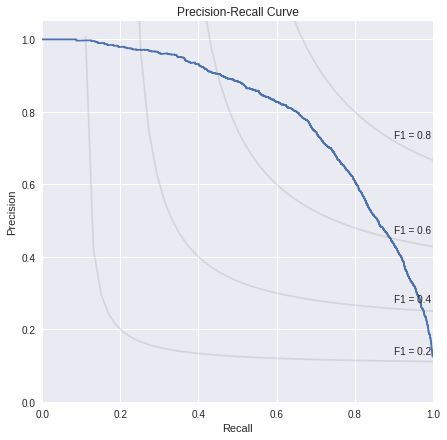

In [321]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_labels, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

In [0]:
# Save for later
precision_lr = precision
recall_lr = recall

**Задание** Придумайте признаки, чтобы улучшить качество модели.

In [0]:
# New feature: First letter expected to be in uppercase, while the rest in lower.

import re
from scipy.sparse import hstack

pattern = re.compile("^[А-Я][а-я]+$")

train_column = np.zeros(len(train_data), dtype=int)
for idx, entity in enumerate(train_data):
    if pattern.match(entity):
        train_column[idx] = 1

test_column = np.zeros(len(test_data), dtype=int)
for idx, entity in enumerate(test_data):
    if pattern.match(entity):
        test_column[idx] = 1

X_train_tuned = hstack((X_train, train_column[:, None])).tocsr()
X_test_tuned = hstack((X_test, test_column[:, None])).tocsr()

In [324]:
model = LogisticRegression().fit(X_train_tuned, train_labels)

test_preds = model.predict(X_test_tuned)
print('F1-score = {:.2%}'.format(f1_score(test_labels, test_preds)))

F1-score = 70.37%


In [0]:
# Save for later
precision_f, recall_f, _ = precision_recall_curve(test_labels, model.predict_proba(X_test_tuned)[:, 1])

## Character-Level Convolutions

### Общее описание сверток

Напомню, свертки - это то, с чего начался хайп нейронных сетей в районе 2012-ого.

Работают они примерно так:  
![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   
From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

Но нужно не забывать, что свертки обычно имеют ещё такую размерность, как число каналов. Например, картинки имеют обычно три канала: RGB.  
Наглядно демонстрируется как выглядят при этом фильтры [здесь](http://cs231n.github.io/convolutional-networks/#conv).

После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность тензора, с которым приходится работать. Самым частым является max-pooling:  
![maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg =x300)  
From [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/#pool)

### Свёртки для текстов

Для текстов свертки работают как n-граммные детекторы (примерно). Каноничный пример символьной сверточной сети:

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png =x500)  
From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

*Сколько учится фильтров на данном примере?*

На картинке показано, как из слова извлекаются 2, 3 и 4-граммы. Например, желтые - это триграммы. Желтый фильтр прикладывают ко всем триграммам в слове, а потом с помощью global max-pooling извлекают наиболее сильный сигнал.

Что это значит, если конкретнее?

Каждый символ отображается с помощью эмбеддингов в некоторый вектор. А их последовательности - в конкатенации эмбеддингов.  
Например, "abs" $\to [v_a; v_b; v_s] \in \mathbb{R}^{3 d}$, где $d$ - размерность эмбеддинга. Желтый фильтр $f_k$ имеет такую же размерность $3d$.  
Его прикладывание - это скалярное произведение $\left([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R$ (один из желтых квадратиков в feature map для данного фильтра).

Max-pooling выбирает $max_i \left( [v_{i-1}; v_{i}; v_{i+1}] \odot f_k \right)$, где $i$ пробегается по всем индексам слова от 1 до $|w| - 1$ (либо по большему диапазону, если есть padding'и).   
Этот максимум соответствует той триграмме, которая наиболее близка к фильтру по косинусному расстоянию.

В результате в векторе после max-pooling'а закодирована информация о том, какие из n-грамм встретились в слове: если встретилась близкая к нашему $f_k$ триграмма, то в $k$-той позиции вектора будет стоять большое значение, иначе - маленькое.

А учим мы как раз фильтры. То есть сеть должна научиться определять, какие из n-грамм значимы, а какие - нет.

### Игрушечный пример

Посмотрим на примере, что там происходит. Возьмем слово:

In [0]:
word = 'Смирнов'

Для начала нужно перенумеровать символы:

In [327]:
char2index = {symb: ind for ind, symb in enumerate(set(word))}

char2index

{'С': 2, 'в': 4, 'и': 5, 'м': 3, 'н': 6, 'о': 1, 'р': 0}

Каждому символу сопоставляется эмбеддинг. Простейший способ сделать эмбеддинги - взять единичную матрицу. Когда у нас были десятки тысяч слов, такие эмбеддинги были не оч, а сейчас всего несколько символов вполне адекватно присвоить им ортогональные вектора небольшой размерности.

In [328]:
embeddings = torch.eye(len(char2index))

embeddings

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])

Построим тензор индексов символов слова:

In [329]:
word_tensor = LongTensor([char2index[symb] for symb in word])

word_tensor

tensor([2, 3, 5, 0, 6, 1, 4], device='cuda:0')

Отобразим его в эмбеддинги. Получили такой же прямоугольничек, как на картинке (транспонирование нужно, чтобы смотрело в ту же сторону).

In [330]:
word_embs = embeddings[word_tensor].t()

word_embs

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]])

Теперь дело дошло до сверток. Сделаем фильтр-детектор триграммы `нов`:

In [331]:
kernel_name = 'нов'

kernel_indices = LongTensor([char2index[symb] for symb in kernel_name])
kernel_weights = embeddings[kernel_indices].t()

kernel_weights

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.],
        [1., 0., 0.]])

Чтобы посчитать свёртку, воспользуемся функцией:

```python
F.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
```

input: input tensor of shape ($N \times C_{in} \times H_{in} \times W_{in}$)  
weight: filters of shape ($C_{out} \times C_{in} \times H_{out} \times W_{out}$)

$N$ - размер батча (1 у нас). $C_{in}$ - число каналов. В нашем случае оно всегда будет 1 (пока что). $C_{out}$ - число фильтров. Оно пока 1.

Нам понадобятся четырехмерные тензоры, для этого воспользуемся `view`:

In [332]:
word_embs = word_embs.view(1, 1, word_embs.shape[0], word_embs.shape[1])
kernel_weights = kernel_weights.view(1, 1, kernel_weights.shape[0], kernel_weights.shape[1])

conv_result = F.conv2d(word_embs, kernel_weights)[0, 0]

print('Conv =', conv_result)
print('Max pooling =', conv_result.max())

Conv = tensor([[0., 0., 0., 0., 3.]])
Max pooling = tensor(3.)


Свертка сказала, что данный фильтр есть на последней позиции. Пулинг сказал, пофиг на какой позиции - главное, он есть.

### Подготовка данных

Первый шаг - определить, какой длины слова у нас. Ограничимся каким-то числом, а более длинные будем обрезать.

In [333]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for word in train_data:
    word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word length for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word length for 99% of words is 17


Соберем отображение из символов в индексы.

In [334]:
chars = set()
for word in train_data:
    chars.update(word)

char_index = {c : i + 1 for i, c in enumerate(chars)}
char_index['<pad>'] = 0
    
print(char_index)

{'Ч': 1, 'е': 2, 'б': 3, 'Ь': 4, 'ó': 5, 'И': 6, 'Ъ': 7, 'ш': 8, 'м': 9, 'в': 10, 'Ю': 11, '.': 12, 'Д': 13, 'н': 14, 'ё': 15, 'Ф': 16, '-': 17, 'Л': 18, 'т': 19, 'З': 20, 'г': 21, 'Ó': 22, '7': 23, '’': 24, 'Г': 25, 'к': 26, 'ч': 27, 'р': 28, 'К': 29, 'Э': 30, '«': 31, 'Ж': 32, '“': 33, ' ': 34, 'ъ': 35, 'Н': 36, 'Щ': 37, '·': 38, 'э': 39, 'Е': 40, 'я': 41, 'ф': 42, '2': 43, 'а': 44, 'з': 45, 'й': 46, 'Б': 47, 'х': 48, '/': 49, '4': 50, 'л': 51, "'": 52, 'ы': 53, 'С': 54, 'Х': 55, 'и': 56, 'Ы': 57, 'Ё': 58, 'Р': 59, 'ю': 60, 'Ш': 61, '»': 62, 'д': 63, 'Я': 64, 'щ': 65, 'ц': 66, 'М': 67, 'п': 68, 'О': 69, 'ж': 70, 'Й': 71, 'В': 72, '”': 73, 'о': 74, 'ь': 75, 'у': 76, 'Ц': 77, 'ѐ': 78, 'У': 79, 'П': 80, 'с': 81, '3': 82, 'Т': 83, 'А': 84, '<pad>': 0}


**Задание** Сконвертируйте данные

In [0]:
def convert_data(data, max_word_len, char_index):
    res = np.zeros((len(data), max_word_len))
    
    for i, word in enumerate(data):
        word = word[-max_word_len:]
        res[i, :len(word)] = [char_index.get(symb, 0) for symb in word]
      
    return res

X_train = convert_data(train_data, MAX_WORD_LEN, char_index)
X_test = convert_data(test_data, MAX_WORD_LEN, char_index)

In [0]:
def iterate_batches(X, y, batch_size):
    num_samples = X.shape[0]

    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        
        batch_idx = indices[start: end]
        
        yield X[batch_idx], y[batch_idx]

### MyFirstConvCharNN

Теперь построим свёрточную модель.

Пусть она будет строить триграммы - то есть применять фильтры на 3 символа.

Начнем с последовательности: `nn.Embedding -> nn.Conv2d -> nn.ReLU -> max pooling -> nn.Linear`

`nn.Conv2d` - это слой, содержащий создание и инициализацию фильтров, и вызов `F.conv2d` к ним и входу.

*Лайфхак:* последовательности операций можно запаковывать в `nn.Sequential`.

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(4, emb_dim)),
            nn.ReLU(inplace=True)
        )
        self._out_layer = nn.Linear(filters_count, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        return self._conv3(self._embedding(inputs).unsqueeze(1)).squeeze(-1).max(-1)[0]

Проверьте, что всё работает:

In [0]:
X_batch, y_batch = next(iterate_batches(X_train, train_labels, 32))
X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)

model = ConvClassifier(len(char_index) + 1, 24, 64).cuda()
logits = model(X_batch)

**Задание** Подсчитайте precision, recall и F1-score для полученных предсказаний.

In [0]:
y_pred = (logits > 0).long()

In [0]:
tp = int((y_pred * y_batch).sum())
fp = int(((1 - y_batch) * y_pred).sum())
fn = int(((1 - y_pred) * y_batch).sum())

In [0]:
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

In [342]:
print('PRECISION: {:.2f}'.format(precision))
print('RECALL: {:.2f}'.format(recall))
print('F1-SCORE: {:.2f}'.format(f1))

PRECISION: 0.12
RECALL: 1.00
F1-SCORE: 0.22


**Задание** Напишем теперь цикл обучения, который не слишком сложно будет переиспользовать

In [0]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss, epoch_tp, epoch_fp, epoch_fn = 0, 0, 0, 0
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(data.shape[0] / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size)):
            X_batch, y_batch = LongTensor(X_batch), FloatTensor(y_batch)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            y_pred = (logits > 0).float()
            tp = int((y_pred * y_batch).sum())
            fp = int(((1 - y_batch) * y_pred).sum())
            fn = int(((1 - y_pred) * y_batch).sum())

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            epoch_tp += tp
            epoch_fp += fp
            epoch_fn += fn

            print('\r[{} / {}]: Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'.format(
                  i, batchs_count, loss.item(), precision, recall, f1), end='')
        
    precision = epoch_tp / (epoch_tp + epoch_fp) if (epoch_tp + epoch_fp) > 0 else 0
    recall = epoch_tp / (epoch_tp + epoch_fn) if (epoch_tp + epoch_fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
    return epoch_loss / batchs_count, recall, precision, f1

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_recall, train_precision, train_f1 = do_epoch(
            model, criterion, train_data, batch_size, optimizer
        )
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
        if not val_data is None:
            val_loss, val_recall, val_precision, val_f1 = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss, train_recall, train_precision, train_f1,
                                     val_loss, val_recall, val_precision, val_f1))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [344]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=35, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 35, Epoch Time = 2.42s: Train Loss = 0.3498, Precision = 1.36%, Recall = 12.11%, F1 = 2.45%, Val Loss = 0.3062, Precision = 2.16%, Recall = 80.68%, F1 = 4.22%
Epoch 2 / 35, Epoch Time = 2.31s: Train Loss = 0.2791, Precision = 11.69%, Recall = 73.08%, F1 = 20.16%, Val Loss = 0.2674, Precision = 16.52%, Recall = 75.28%, F1 = 27.10%
Epoch 3 / 35, Epoch Time = 2.31s: Train Loss = 0.2476, Precision = 26.40%, Recall = 74.59%, F1 = 39.00%, Val Loss = 0.2423, Precision = 31.55%, Recall = 76.89%, F1 = 44.75%
Epoch 4 / 35, Epoch Time = 2.31s: Train Loss = 0.2276, Precision = 36.48%, Recall = 75.56%, F1 = 49.21%, Val Loss = 0.2274, Precision = 39.76%, Recall = 76.12%, F1 = 52.23%
Epoch 5 / 35, Epoch Time = 2.35s: Train Loss = 0.2134, Precision = 42.34%, Recall = 76.90%, F1 = 54.61%, Val Loss = 0.2178, Precision = 42.01%, Recall = 77.55%, F1 = 54.50%
Epoch 6 / 35, Epoch Time = 2.33s: Train Loss = 0.2018, Precision = 47.00%, Recall = 78.18%, F1 = 58.70%, Val Loss = 0.2098, Precision = 49.

**Задание** Проверьте работу классификатора на вашей фамилии.

Нужно не забыть перевести модель в режим инференса - некоторые слои на трейне и инференсе ведут себя по-разному.

In [352]:
model.eval()

surname = 'Рубаненко'
surname_tensor = LongTensor(convert_data([surname], len(surname), char_index))
print('P({} is surname) = {}'.format(surname, torch.sigmoid(model(surname_tensor))))

P(Рубаненко is surname) = tensor([0.0901], device='cuda:0', grad_fn=<SigmoidBackward>)


**Задание** Постройте precision-recall curve для данного классификатора и предыдущей модели

In [0]:
X_test = LongTensor(X_test)
y_pred = model(X_test).cpu().detach().numpy()

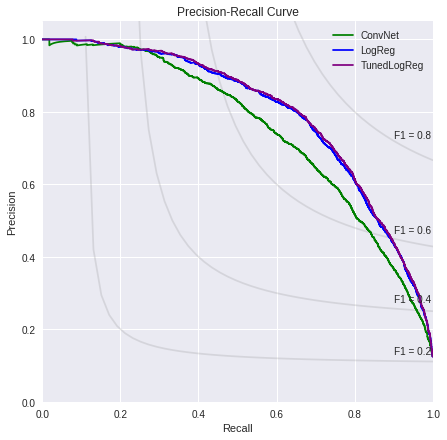

In [354]:
precision, recall, _ = precision_recall_curve(test_labels, y_pred)

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision, c='g', label='ConvNet')
plt.plot(recall_lr, precision_lr, c='b', label='LogReg')
plt.plot(recall_f, precision_f, c='purple', label='TunedLogReg')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()

## Визуализации

### Визуализация эмбеддингов

**Задание** Визуализируем эмбеддинги слов, как это делали раньше

In [0]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

In [356]:
word_indices = np.random.choice(np.arange(len(test_data)), 1000, replace=False)
words = [test_data[ind] for ind in word_indices]
labels = test_labels[word_indices]

word_tensor = convert_data(words, max(len(x) for x in words), char_index)
word_tensor = LongTensor(word_tensor)
embeddings = model.embed(word_tensor).cpu().detach().numpy()

colors = ['red' if label else 'blue' for label in labels]

visualize_embeddings(embeddings, words, colors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.300s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.052439
[t-SNE] Computed conditional probabilities in 0.067s
[t-SNE] Iteration 50: error = 73.9638443, gradient norm = 0.3238610 (50 iterations in 2.823s)
[t-SNE] Iteration 100: error = 74.7148285, gradient norm = 0.2939531 (50 iterations in 2.421s)
[t-SNE] Iteration 150: error = 74.8105240, gradient norm = 0.3095033 (50 iterations in 2.436s)
[t-SNE] Iteration 200: error = 73.7264633, gradient norm = 0.3112523 (50 iterations in 2.615s)
[t-SNE] Iteration 250: error = 74.3699417, gradient norm = 0.3191932 (50 iterations in 2.617s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.369942
[t-SNE] Iteration 300: error = 1.6763242, gradient norm = 0.0026757 (50 iterations in 2.063s)
[t-SNE] Iteration 350: error = 1.5643306, gradient norm = 0.00059

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

### Визуализация полученных свёрток

Кроме всего прочего у нас тут логистическая регрессия сверху. Можно визуализировать ее также, как в eli5.

**Задание** Добиться этого.

In [0]:
model.eval()

word = 'Смирнов'

Посчитайте вероятность, что слово - фамилия.

In [0]:
inputs = LongTensor(convert_data([word], len(word), char_index))
prob = torch.sigmoid(model(inputs)).item()

Посчитайте результат свертки и пулинга

In [0]:
convs = model._conv3(model._embedding(inputs).unsqueeze(1))
maxs, positions = convs.squeeze().max(-1)

Домножьте выход пулинга на веса выходного слоя

In [0]:
linear_weights = (maxs * model._out_layer.weight).cpu().detach().numpy()[0]

Посчитайте веса символов: каждый фильтр прикладывается к какой-то позиции - прибавим его вес к накрываемым символам.

In [0]:
# We wrote our ConvNN with kernel_size == 4
KERNEL_SIZE = 4

symb_weights = np.zeros(len(word))
for idx, position in enumerate(positions):
    for i in range(KERNEL_SIZE):
        symb_weights[position + i] += linear_weights[idx]

In [377]:
symb_weights

array([ 2.31348729,  0.71361016, -0.27274263,  0.29698434, -2.01650295,
       -0.41662582,  0.56972697])

Визуализируем это:

In [378]:
from IPython.core.display import HTML

def get_color_hex(weight):
    cmap = plt.get_cmap("RdYlGn")
    rgba = cmap(weight, bytes=True)
    return '#%02X%02X%02X' % rgba[:3]

symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
res = '<p>P(surname) = {:.2%}</p>'.format(prob)
for symb, weight in zip(word, symb_weights):
    res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
res = '<p>' + res + '</p>'

HTML(res)

Объединим все в функции:

In [381]:
def calc_weights(word):
    inputs = LongTensor(convert_data([word], len(word), char_index))
    prob = torch.sigmoid(model(inputs)).item()
    
    convs = model._conv3(model._embedding(inputs).unsqueeze(1))
    maxs, positions = convs.squeeze().max(-1)
    
    linear_weights = (maxs * model._out_layer.weight).cpu().detach().numpy()[0]
    
    symb_weights = np.zeros(len(word))
    for idx, position in enumerate(positions):
        for i in range(KERNEL_SIZE):
            symb_weights[position + i] += linear_weights[idx]
    
    return prob, symb_weights

def visualize(word):
    prob, symb_weights = calc_weights(word)
    
    symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
    res = '<p>P(surname) = {:.2%}</p>'.format(prob)
    for symb, weight in zip(word, symb_weights):
        res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
    res = '<p>' + res + '</p>'
    return HTML(res)


visualize('Королев')

## Улучшение модели

**Задание** Для улучшение стабильности модели стоит добавить дропаут `nn.Dropout` - способ занулять часть весов на каждой эпохе для регуляризации модели. Попробуйте добавить его после эмбеддингов и после свертки (а можно еще где-нибудь).

![](https://cdn-images-1.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png =x300)

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.2)
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(4, emb_dim)),
            nn.ReLU(inplace=True)
        )
        self._out_layer = nn.Linear(filters_count, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self._dropout(self.embed(inputs))
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        embs = self._dropout(self._embedding(inputs).unsqueeze(1))
        return self._conv3(embs).squeeze(-1).max(-1)[0]

In [205]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=80, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 80, Epoch Time = 2.45s: Train Loss = 0.3462, Precision = 0.95%, Recall = 15.90%, F1 = 1.79%, Val Loss = 0.3068, Precision = 3.29%, Recall = 63.16%, F1 = 6.26%
Epoch 2 / 80, Epoch Time = 2.34s: Train Loss = 0.2967, Precision = 7.46%, Recall = 64.59%, F1 = 13.38%, Val Loss = 0.2729, Precision = 16.46%, Recall = 69.68%, F1 = 26.63%
Epoch 3 / 80, Epoch Time = 2.34s: Train Loss = 0.2760, Precision = 18.95%, Recall = 66.94%, F1 = 29.54%, Val Loss = 0.2571, Precision = 36.10%, Recall = 65.70%, F1 = 46.60%
Epoch 4 / 80, Epoch Time = 2.36s: Train Loss = 0.2618, Precision = 26.37%, Recall = 67.57%, F1 = 37.94%, Val Loss = 0.2408, Precision = 32.32%, Recall = 73.15%, F1 = 44.83%
Epoch 5 / 80, Epoch Time = 2.36s: Train Loss = 0.2513, Precision = 31.24%, Recall = 67.85%, F1 = 42.79%, Val Loss = 0.2353, Precision = 45.06%, Recall = 69.13%, F1 = 54.56%
Epoch 6 / 80, Epoch Time = 2.34s: Train Loss = 0.2469, Precision = 33.59%, Recall = 69.02%, F1 = 45.19%, Val Loss = 0.2290, Precision = 45.5

**Задание** Другой способ регуляризовывать модель - использовать BatchNormalization (`nn.BatchNorm2d`). Попробуйте добавить его после свертки.

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.4)
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(4, emb_dim)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._out_layer = nn.Linear(filters_count, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        embs = self._dropout(self._embedding(inputs).unsqueeze(1))
        return self._conv3(embs).squeeze(-1).max(-1)[0]

In [220]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=80, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 80, Epoch Time = 2.56s: Train Loss = 0.3347, Precision = 0.87%, Recall = 43.85%, F1 = 1.71%, Val Loss = 0.3132, Precision = 16.22%, Recall = 58.27%, F1 = 25.38%
Epoch 2 / 80, Epoch Time = 2.44s: Train Loss = 0.2953, Precision = 9.93%, Recall = 66.87%, F1 = 17.29%, Val Loss = 0.2816, Precision = 38.45%, Recall = 61.30%, F1 = 47.26%
Epoch 3 / 80, Epoch Time = 2.45s: Train Loss = 0.2771, Precision = 19.72%, Recall = 67.42%, F1 = 30.52%, Val Loss = 0.2766, Precision = 51.10%, Recall = 58.44%, F1 = 54.52%
Epoch 4 / 80, Epoch Time = 2.45s: Train Loss = 0.2671, Precision = 24.10%, Recall = 67.54%, F1 = 35.53%, Val Loss = 0.2528, Precision = 50.85%, Recall = 63.64%, F1 = 56.53%
Epoch 5 / 80, Epoch Time = 2.44s: Train Loss = 0.2570, Precision = 28.64%, Recall = 69.12%, F1 = 40.50%, Val Loss = 0.2443, Precision = 52.44%, Recall = 65.55%, F1 = 58.27%
Epoch 6 / 80, Epoch Time = 2.45s: Train Loss = 0.2521, Precision = 30.39%, Recall = 68.95%, F1 = 42.18%, Val Loss = 0.2354, Precision = 54

**Задание** Еще способ улучшить модель - добавить сверток. Реализуйте модель как на картинке в начале ноутбука: со свертками на 2, 3, 4 символа.

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.3)
        self._conv32 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(2, emb_dim)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._conv33 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(3, emb_dim)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._conv34 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(4, emb_dim)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._out_layer = nn.Linear(filters_count * 3, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        embs = self._dropout(self._embedding(inputs).unsqueeze(1))
        small = self._conv32(embs).squeeze(-1).max(-1)[0]
        medium = self._conv33(embs).squeeze(-1).max(-1)[0]
        large = self._conv34(embs).squeeze(-1).max(-1)[0]
        return torch.cat((small, medium, large), 1)

In [224]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=80, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 80, Epoch Time = 4.10s: Train Loss = 0.3310, Precision = 2.62%, Recall = 31.78%, F1 = 4.84%, Val Loss = 0.2911, Precision = 18.99%, Recall = 60.78%, F1 = 28.94%
Epoch 2 / 80, Epoch Time = 4.01s: Train Loss = 0.2786, Precision = 14.34%, Recall = 68.92%, F1 = 23.74%, Val Loss = 0.2568, Precision = 38.66%, Recall = 64.40%, F1 = 48.31%
Epoch 3 / 80, Epoch Time = 4.01s: Train Loss = 0.2565, Precision = 26.62%, Recall = 69.42%, F1 = 38.48%, Val Loss = 0.2460, Precision = 54.09%, Recall = 62.55%, F1 = 58.01%
Epoch 4 / 80, Epoch Time = 4.06s: Train Loss = 0.2442, Precision = 32.95%, Recall = 70.93%, F1 = 44.99%, Val Loss = 0.2382, Precision = 57.96%, Recall = 62.12%, F1 = 59.97%
Epoch 5 / 80, Epoch Time = 4.02s: Train Loss = 0.2382, Precision = 36.21%, Recall = 71.00%, F1 = 47.96%, Val Loss = 0.2301, Precision = 58.48%, Recall = 63.91%, F1 = 61.07%
Epoch 6 / 80, Epoch Time = 4.00s: Train Loss = 0.2317, Precision = 38.11%, Recall = 71.26%, F1 = 49.66%, Val Loss = 0.2265, Precision = 6

**Задание** Различают Narrow и Wide свёртки - по сути, добавляется ли нулевой паддинг или нет. Для текстов эта разница выглядит так:  
![narrow_vs_wide](https://image.ibb.co/eqGZaS/2018_03_28_11_23_17.png)
*From Neural Network Methods in Natural Language Processing.*

Слева - паддинг отсутствует, справа - есть. Попробуйте добавить паддинг и посмотреть, что получится. Потенциально он поможет выучить хорошие префиксы слова.

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.3)
        self._conv32 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(2, emb_dim), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._conv33 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(3, emb_dim), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._conv34 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(4, emb_dim), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._out_layer = nn.Linear(filters_count * 3, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        embs = self._dropout(self._embedding(inputs).unsqueeze(1))
        small = self._conv32(embs).squeeze(-1).max(-1)[0]
        medium = self._conv33(embs).squeeze(-1).max(-1)[0]
        large = self._conv34(embs).squeeze(-1).max(-1)[0]
        return torch.cat((small, medium, large), 1)

In [310]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=80, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 80, Epoch Time = 4.15s: Train Loss = 0.3207, Precision = 2.79%, Recall = 58.90%, F1 = 5.33%, Val Loss = 0.2932, Precision = 26.62%, Recall = 58.67%, F1 = 36.62%
Epoch 2 / 80, Epoch Time = 4.10s: Train Loss = 0.2785, Precision = 16.00%, Recall = 66.29%, F1 = 25.77%, Val Loss = 0.2661, Precision = 44.51%, Recall = 59.84%, F1 = 51.05%
Epoch 3 / 80, Epoch Time = 4.02s: Train Loss = 0.2602, Precision = 24.33%, Recall = 66.03%, F1 = 35.56%, Val Loss = 0.2571, Precision = 55.55%, Recall = 58.68%, F1 = 57.07%
Epoch 4 / 80, Epoch Time = 4.03s: Train Loss = 0.2498, Precision = 30.46%, Recall = 69.10%, F1 = 42.28%, Val Loss = 0.2368, Precision = 51.34%, Recall = 64.08%, F1 = 57.01%
Epoch 5 / 80, Epoch Time = 4.02s: Train Loss = 0.2397, Precision = 34.52%, Recall = 70.38%, F1 = 46.32%, Val Loss = 0.2332, Precision = 57.74%, Recall = 63.92%, F1 = 60.68%
Epoch 6 / 80, Epoch Time = 4.04s: Train Loss = 0.2346, Precision = 37.47%, Recall = 70.87%, F1 = 49.02%, Val Loss = 0.2174, Precision = 5

Как видим, самая последняя сетка "*Dropout + Batch Normalization + 3 Convolution Layers*" превосходит успех модели "*Logistic Regression + New Feature*".

# Сдача задания

[Форма](https://goo.gl/forms/FfMnyNGI2P4xo0QD3)